# Data Integration

## Import

In [1]:
#### COLAB ONLY CELL
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount('/content/gdrive',force_remount=True)
%cd /content/gdrive/MyDrive/COMEXT
%pip install -q powerlaw

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/COMEXT


In [2]:
import hashlib, random, math, os, sys, pickle, time, zipfile, io, json#, powerlaw #,eurostat
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm, trange
from networkx.classes.function import degree
import matplotlib.pyplot as plt
from matplotlib import cm

sys.path.append('/content/gdrive/MyDrive/COMEXT/comext_graph_analysis/src')
import graph_analysis as g

# WTO Data

In [ ]:
df = pd.read_parquet("data-samples/wto/bilateral6_years/wto_df_2001.parquet")

In [ ]:
def dig2(x):
    return str(x)[:2]

def int2str(x,l):
    if l == 6:
        return f"{x:06d}"
    elif l == 3:
        return f"{x:03d}"
    elif l == 2:
        return f"{x:02d}"

def year_to_per(x):
    return str(x)+"52"

In [ ]:
reporters = pd.read_json("./data-samples/wto/WTO_ReportingEconomies.json")
partners = pd.read_json("./data-samples/wto/WTO_PartnerEconomies.json")
iso3_to_iso2 = pd.read_csv("./data-samples/nomenclature/wikipedia-iso-country-codes.csv",na_filter=False)
usd_eur = pd.read_csv("data-samples/wto/usd_eur_ecb.csv")
hs_to_cpa = pd.read_csv("data-samples/nomenclature/HS_2007-CPA_2008.csv",dtype=str)
cpa08_to_cpa21 = pd.read_csv("data-samples/nomenclature/CPA_2.1-CPA_2008.csv",dtype=str)

In [ ]:
usd_eur = usd_eur[~usd_eur.annual_value.isna()].reset_index(drop=True)
usd_eur["year"] = usd_eur.date.str[:4].apply(lambda x: int(x))
usd_eur = usd_eur.set_index("year")["annual_value"].to_dict()
iso3_to_iso2.numeric = iso3_to_iso2.numeric.apply(lambda x: int2str(x,3))
code_to_iso2_dic = iso3_to_iso2.set_index("numeric")["alpha_2"].to_dict()
code_to_iso2_dic["918"] = "EU"
code_to_iso2_dic["899"] = "EU"
code_to_iso2_dic["228"] = "EUN"
hs_to_cpa_dic = hs_to_cpa.set_index("HS_2007")["CPA_2008"].to_dict()
cpa08_to_cpa21_dic = cpa08_to_cpa21.set_index("CPA 2.1")["CPA 2008"].to_dict()

In [ ]:
# wto_countries = partners[partners.columns[:-1]].merge(reporters[reporters.columns[:-1]],how="outer").merge(iso3_to_iso2, left_on="iso3A",right_on="alpha-3",how="outer")
# wto_countries = wto_countries[(~wto_countries.code.isna())]#&(~wto_countries["alpha-2"].isna())]
# wto_countries_dic = wto_countries.set_index("code")["alpha-2"].to_dict()
# iso2_to_iso3_dic = iso3_to_iso2.set_index("alpha-2")["alpha-3"].to_dict()

In [ ]:
def get_country_code(x):
    try:
        # return iso2_to_iso3_dic[wto_countries_dic[x]]
        return code_to_iso2_dic[x]
    except:
        return "X"

def usd_eur_conv(x,y):
    return x/usd_eur[y]

def get_cpa(x):
    try:
        return cpa08_to_cpa21_dic[hs_to_cpa_dic[x]][:4]
    except:
        return x

def comextify(df):
    df.ProductOrSectorCode = df.ProductOrSectorCode.apply(lambda x: int2str(x,6))
    df.ReportingEconomyCode = df.ReportingEconomyCode.apply(lambda x: int2str(x,3))
    df.PartnerEconomyCode = df.PartnerEconomyCode.apply(lambda x: int2str(x,3))
    df["ReportingEconomy_iso2"] = df.ReportingEconomyCode.apply(get_country_code)
    df["PartnerEconomy_iso2"] = df.PartnerEconomyCode.apply(get_country_code)
    yr = df.Year.iloc[0]
    df["Value"] = df.Value.apply(lambda x: usd_eur_conv(x,yr))
    df["ProductOrSectorCode"] = df.ProductOrSectorCode.apply(get_cpa)
    df["Year52"] = df.Year.apply(year_to_per)
    df["FLOW"] = 1
    df["QUANTITY_IN_KG"] = 0
    col_to_comext = {
        'ProductOrSectorCode':"PRODUCT_CPA2_1",
        'ReportingEconomy_iso2':"DECLARANT_ISO",
        'PartnerEconomy_iso2':"PARTNER_ISO",
        'Year52':"PERIOD",
        'Value':"VALUE_IN_EUROS"
    }
    wto_cols = [k for k in col_to_comext]
    wto_cols.insert(3,"FLOW")
    wto_cols.append("QUANTITY_IN_KG")
    return df[wto_cols].rename(col_to_comext,axis=1)

In [3]:
for f in tqdm(os.listdir("data-samples/wto/Years/")):
    # if not os.path.exists("data-samples/wto/wto_comextify/"+f):
    df = pd.read_parquet("data-samples/wto/Years/"+f)
    # df_com = comextify(df)
    df.reset_index(drop=True).to_parquet("data-samples/wto/Years/"+f)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
df = pd.read_parquet("data-samples/wto/bilateral6_years/wto_df_2001.parquet")
# df_wto = pd.read_parquet("data-samples/wto/wto_comextify/wto_df_2001.parquet")
df_wto = comextify(df)

In [ ]:
df_par = pd.read_parquet("data-samples/full/Months/full200101.parquet")

In [ ]:
df_par

,DECLARANT,DECLARANT_ISO,PARTNER,PARTNER_ISO,TRADE_TYPE,PRODUCT_NC,PRODUCT_SITC,PRODUCT_cpa2002,PRODUCT_cpa2008,PRODUCT_CPA2_1,PRODUCT_BEC,PRODUCT_SECTION,FLOW,STAT_REGIME,SUPP_UNIT,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG,SUP_QUANTITY
0,1,FR,3,NL,I,01011100,00151,0122,0143,0143,111,01,1,1,A,200101,2580,600,1
1,1,FR,3,NL,I,01011990,00151,0122,0143,0143,111,01,1,1,A,200101,120347,1800,3
2,1,FR,3,NL,I,01012090,00152,0122,0143,0143,111,01,1,1,A,200101,9904,2700,10
3,1,FR,3,NL,I,01021030,00111,0121,0141,0141,410,01,2,1,A,200101,10249,6700,11
4,1,FR,3,NL,I,01021090,00111,0121,0142,0142,410,01,1,1,A,200101,189637,46800,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766171,600,CY,958,QU,E,84798998,72849,2956,2899,2751,410,16,1,1,,200101,234,0,0
2766172,600,CY,958,QU,E,84807900,74919,2956,2573,2573,410,16,1,1,,200101,258,200,0
2766173,600,CY,958,QU,E,94037090,82171,3614,3109,3109,610,20,1,1,,200101,234,20,0
2766174,600,CY,958,QU,E,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TO,1,1,,200101,377964,402982,0


In [ ]:
cn_to_cpa = pd.read_table("data-samples/nomenclature/CN8_CPA21.txt",names=["cn","cpa","start_date","end_date"])

In [ ]:
# cn_to_cpa[cn_to_cpa[["cn","cpa"]].duplicated(keep=False)]
cn_to_cpa["cn"] = cn_to_cpa.cn.str[:6]
cn_to_cpa[(cn_to_cpa.end_date >= "31/12/2022")][["cn","cpa"]]

,cn,cpa
7,010121,014311
8,010129,014311
9,010129,014311
10,010130,014312
11,010190,014312
...,...,...
22506,99YYY9,YYYY00
22507,99YYY9,YYYY00
22508,99YYY9,YYYY00
22509,99YYY9,YYYY00


In [ ]:
# df_par.PRODUCT_NC.str[:6].unique()
cn = pd.read_table("data-samples/nomenclature/CN.txt",header=None,names=[
    "code","date_start","date_end","type","desc","date_start2","date_end2"                                                                     
    ])
cn

,code,date_start,date_end,type,desc,date_start2,date_end2
0,00,01/01/1988,31/12/1998,LIBEN,Total for countries whose data are confidentia...,01/01/1988,31/12/1998
1,0090,01/01/1988,31/12/1998,LIBEN,Total for countries whose data are confidentia...,01/01/1988,31/12/1998
2,009000,01/01/1988,31/12/1998,LIBEN,Total for countries whose data are confidentia...,01/01/1988,31/12/1998
3,00900000,01/01/1988,31/12/1998,LIBEN,Total for countries whose data are confidentia...,01/01/1988,31/12/1998
4,01,01/01/1988,31/12/2500,LIBEN,LIVE ANIMALS,01/01/1988,31/12/2500
...,...,...,...,...,...,...,...
32383,99YYY960,01/01/1993,31/12/2500,LIBEN,"Trade under the declaration limit, SITC 96",01/01/1993,31/12/2500
32384,99YYY970,01/01/1993,31/12/2500,LIBEN,"Trade under the declaration limit, SITC 97",01/01/1993,31/12/2500
32385,99YYY980,01/01/1993,31/12/2500,LIBEN,"Trade under the declaration limit, SITC 98",01/01/1993,31/12/2500
32386,99YYY990,01/01/1993,31/12/2500,LIBEN,"Trade under the declaration limit, SITC 99",01/01/1993,31/12/2500


In [ ]:
(cn.date_start == cn.date_start2).all(), (cn.date_end == cn.date_end2).all()

(True, True)

In [ ]:
cn[cn.code.duplicated(keep=False)]

,code,date_start,date_end,type,desc,date_start2,date_end2
78,01029099,01/01/2012,31/12/2012,LIBEN,"Live bovine animals (excl. cattle, buffalo, pu...",01/01/2012,31/12/2012
79,01029099,01/01/2013,31/12/2500,LIBEN,"Live bovine animals (excl. cattle, buffalo, pu...",01/01/2013,31/12/2500
132,0106,01/01/1988,31/12/2001,LIBEN,"Live animals (excl. horses, asses, mules, hinn...",01/01/1988,31/12/2001
133,0106,01/01/2002,31/12/2500,LIBEN,"Live animals (excl. horses, asses, mules, hinn...",01/01/2002,31/12/2500
143,01061200,01/01/2002,31/12/2011,LIBEN,"Live whales, dolphins and purpoises ""mammals o...",01/01/2002,31/12/2011
...,...,...,...,...,...,...,...
32119,99CCC000,01/01/2002,31/12/2500,LIBEN,Corrections due to erroneous codes belonging t...,01/01/2002,31/12/2500
32136,99III0,01/01/1988,31/12/2005,LIBEN,"Components of complete industrial plants, not ...",01/01/1988,31/12/2005
32137,99III0,01/01/2006,31/12/2500,LIBEN,"Components of complete industrial plants, not ...",01/01/2006,31/12/2500
32138,99III000,01/01/1988,31/12/2005,LIBEN,"Components of complete industrial plants, not ...",01/01/1988,31/12/2005


In [ ]:
cn6 = cn[cn.code.str.len() == 6]

In [ ]:
# df["HS6"] = df.ProductOrSectorCode.apply(lambda x: int2str(x,6))
df[~df.HS6.isin(cn6.code)].HS6.unique()

array([], dtype=object)

In [ ]:
full_columns = ["PRODUCT"]

In [ ]:
df_com, _ = g.load_filtered_data("full", save=True, force_reload=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=False, n_digits=2,
                             years=[2001], months=None, product="all", flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

loading full: loading existing... Table loaded


In [ ]:
df_wto_eu = df_wto[df_wto.DECLARANT_ISO.isin(df_com.DECLARANT_ISO.unique())]
df_wto_ex = df_wto[~df_wto.DECLARANT_ISO.isin(df_com.DECLARANT_ISO.unique())]

In [ ]:
df_wto_eu.PRODUCT_CPA2_1[~df_wto_eu.PRODUCT_CPA2_1.isin(df_com.PRODUCT_CPA2_1.unique())].unique()

array(['XXXX'], dtype=object)

In [ ]:
df

## Combine comext-wto

In [3]:
def combine_sources(df_com, df_wto):
    df_extra = df_wto[~(df_wto.DECLARANT_ISO.isin(df_com.DECLARANT_ISO.unique()))&~(df_wto.PARTNER_ISO.isin(df_com.DECLARANT_ISO.unique()))]
    return pd.concat([df_com,df_extra],axis=0).reset_index(drop=True)

In [4]:
df_com, _ = g.load_filtered_data("full", save=True, verbose=2, force_reload=False, types=g.full_types, columns=g.full_columns, group_by_prod_code=True, n_digits=2,
                             years=[2001], months=None, product="all", flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")
df_wto, _ = g.load_filtered_data("wto", save=True, verbose=2, force_reload=False, types=g.full_types, columns=g.full_columns, group_by_prod_code=True, n_digits=2,
                             years=[2001], months=None, product="all", flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

loading full: loading existing... Table loaded
loading wto: 

  0%|          | 0/1 [00:00<?, ?it/s]

2001 
Failed saving, Table loaded


In [5]:
df_complete = combine_sources(df_com,df_wto)

In [8]:
df_complete

,PRODUCT_CPA2_1,DECLARANT_ISO,PARTNER_ISO,FLOW,PERIOD,VALUE_IN_EUROS,QUANTITY_IN_KG
0,TO,NL,DE,2,200152,68898549848,121845756100
1,TO,DE,NL,1,200152,60566174981,105697248300
2,TO,BE,NL,1,200152,34139306816,91226603900
3,TO,DE,NL,2,200152,40010936938,69725177900
4,TO,NL,BE,2,200152,29652953201,67981575500
...,...,...,...,...,...,...,...
309372,19,AU,NZ,1,200152,2902744,0
309373,19,AU,PH,1,200152,844774,0
309374,19,AU,SA,1,200152,50687380,0
309375,19,AU,SG,1,200152,6905451,0


In [22]:
def makeGraph(tab_edges, tab_nodes=None, pos_ini=None, weight_flag=False, criterio="VALUE_IN_EUROS", threshold=0.001, compute_layout=False):
    if tab_nodes is None:
        df_pop, eu_iso = g.load_population_df()
        tab_nodes = g.get_world_countries(df_pop, eu_iso, year=int(tab_edges.columns.name))

    G = nx.DiGraph()
    edges = []
    if weight_flag == True:
        for i,j,w in tab_edges.loc[:,["country_from","country_to",criterio+"_SCALED"]].values:
            if i == "EU" or j == "EU":
                print(i,j)
            edges += [(i,j,w)]
    else:
        for i,j in tab_edges.loc[:,["country_from","country_to"]].values:
            if i == "EU" or j == "EU":
                print(i,j)
            edges += [(i,j,1)]

    G.add_nodes_from(tab_nodes)
    G.add_weighted_edges_from(edges)

    # Calcolo le metriche
    MetricG = g.calc_metrics(G, y=tab_edges.columns.name)
    MetricG = MetricG.merge(tab_edges.groupby(["country_from"])[criterio].sum().rename("out_weight_abs"),left_index=True,right_index=True,how="left")\
                     .merge(tab_edges.groupby(["country_to"])[criterio].sum().rename("in_weight_abs"),left_index=True,right_index=True,how="left").fillna(0)
    MetricG.index.name = "country"

    if compute_layout:
        if pos_ini is None:
            pos_ini = {}
            random.seed(8)
            for node in G.nodes():
                x = random.uniform(0, 1000)
                y = random.uniform(0, 1000)
                pos_ini[node] = np.array([x,y])
        coord = nx.spring_layout(G,k=20/math.sqrt(G.order()))

    return coord, MetricG, G

In [23]:
t4g = g.extract_table_for_graph(df_complete[df_complete.PRODUCT_CPA2_1 == "TO"].copy(), y="2001", flow="all", scale_by='population')
coord, metrics, G = makeGraph(t4g, weight_flag=True, compute_layout=True)
metrics.sort_values("out_weight_degree", ascending=False)

,edges,nodes,size,degree,degree_perc,out_degree,out_degree_perc,in_degree,in_degree_perc,density,...,in_degree_gamma,in_degree_xmin,out_degree_gamma,out_degree_xmin,in_weight_degree_gamma,in_weight_degree_xmin,out_weight_degree_gamma,out_weight_degree_xmin,out_weight_abs,in_weight_abs
country,,,,,,,,,,,,,,,,,,,,,
FR,16633,255,6.633169e+08,345,1.358268,121,0.476378,224,0.881890,0.256801,...,15.061436,192.0,176.170687,120.0,1.979666,2.288797e+06,1.853264,2.782528e+06,2.469846e+11,3.718051e+11
DE,16633,255,6.633169e+08,352,1.385827,123,0.484252,229,0.901575,0.256801,...,15.061436,192.0,176.170687,120.0,1.979666,2.288797e+06,1.853264,2.782528e+06,4.293889e+11,5.562453e+11
GB,16633,255,6.633169e+08,346,1.362205,122,0.480315,224,0.881890,0.256801,...,15.061436,192.0,176.170687,120.0,1.979666,2.288797e+06,1.853264,2.782528e+06,1.864477e+11,4.003969e+11
US,16633,255,6.633169e+08,272,1.070866,120,0.472441,152,0.598425,0.256801,...,15.061436,192.0,176.170687,120.0,1.979666,2.288797e+06,1.853264,2.782528e+06,8.038601e+11,9.660388e+11
IT,16633,255,6.633169e+08,325,1.279528,116,0.456693,209,0.822835,0.256801,...,15.061436,192.0,176.170687,120.0,1.979666,2.288797e+06,1.853264,2.782528e+06,1.775813e+11,2.639812e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EH,16633,255,6.633169e+08,0,0.000000,0,0.000000,0,0.000000,0.256801,...,15.061436,192.0,176.170687,120.0,1.979666,2.288797e+06,1.853264,2.782528e+06,0.000000e+00,0.000000e+00
CW,16633,255,6.633169e+08,0,0.000000,0,0.000000,0,0.000000,0.256801,...,15.061436,192.0,176.170687,120.0,1.979666,2.288797e+06,1.853264,2.782528e+06,0.000000e+00,0.000000e+00
BQ,16633,255,6.633169e+08,0,0.000000,0,0.000000,0,0.000000,0.256801,...,15.061436,192.0,176.170687,120.0,1.979666,2.288797e+06,1.853264,2.782528e+06,0.000000e+00,0.000000e+00


In [24]:
# nx.write_gexf(G,"./data-samples/graphs/complete2001_TO.gexf")

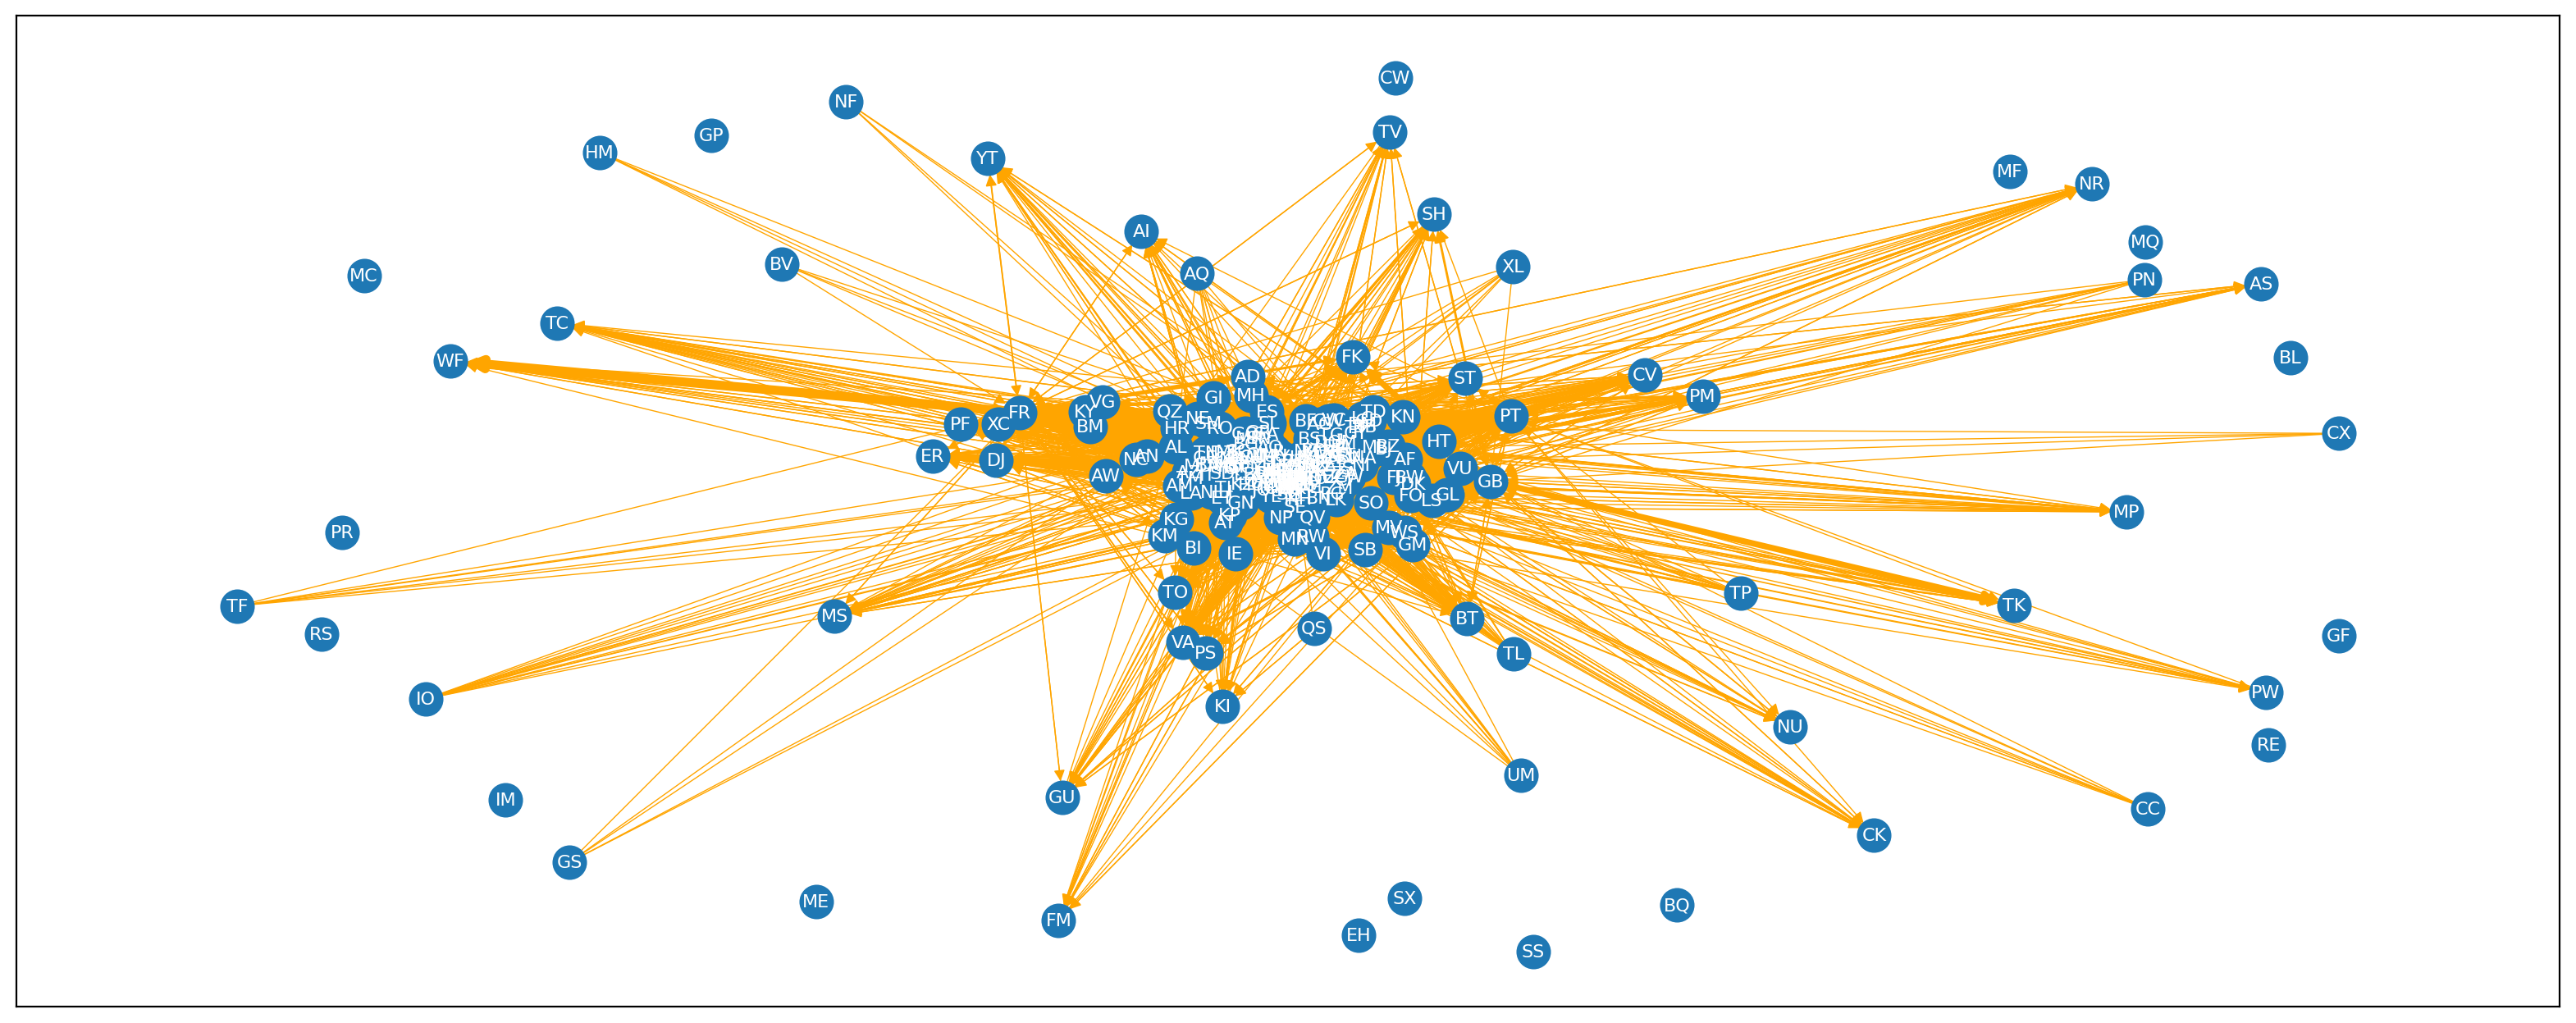

In [25]:
plt.figure(figsize=(20,8),dpi=200)
edg_color = [G.get_edge_data(u,v)["weight"] for u,v in G.edges()]
m = max(edg_color)
edg_color = [(i/m)*256 + 30 for i in edg_color]
nx.draw_networkx(G, pos=coord, edge_color="orange", width=[i/60 for i in edg_color], font_color="white", font_size=8, node_size=200)
plt.show()